In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
class Value:
    def __init__(self, data, _children=(), _operation="", label=""):
        self.data = data
        self.grad = 0.0
        # set for efficiency
        self._prev = set(_children)
        self._operation = _operation
        self.label = label

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")
    
    def __sub__(self, other):
        return Value(self.data - other.data, (self, other), "-")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
    def __truediv__(self, other):
        return Value(self.data / other.data, (self, other), "/")
    
    def __repr__(self):
        return f"Value(data={self.data})"

In [131]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)

            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for node in nodes:
        uid = str(id(node))

        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (node.label, node.data, node.grad), shape="record")

        if node._operation:
            dot.node(name=uid + node._operation, label=node._operation)
            dot.edge(uid + node._operation, uid)
        
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

    return dot


### Manual backpropagation - simple expression

In [132]:
# inputs:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

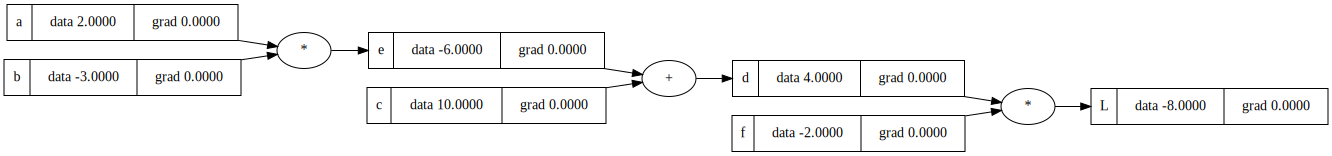

In [133]:
draw_graph(L)

In [155]:
def check_derivative(x):
    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data

    
    a = Value(2.0 , label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    if x.label == "a":
        a.data += h
    elif x.label == "b":
        b.data += h
    elif x.label == "c":
        c.data += h
    
    e = a * b; e.label = "e"
    if x.label == "e":
        e.data += h

    d = e + c; d.label = "d"
    if x.label == "d":
        d.data += h

    f = Value(-2.0, label="f")
    if x.label == "f":
        f.data += h
        
    L = d * f; L.label = "L"
    if x.label == "L":
        L.data += h
        
    L2 = L.data

    print((L2 - L1) / h)


1.000000000000334


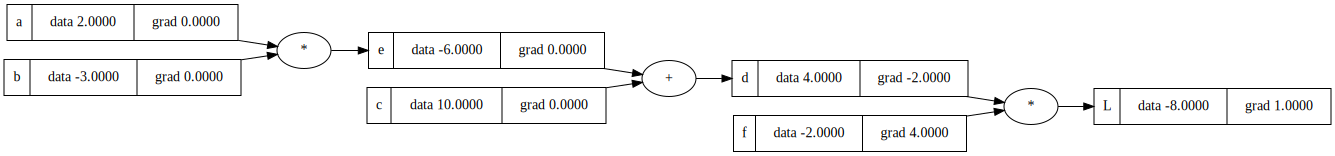

In [149]:
L.grad = 1.0
check_derivative(L)
draw_graph(L)

-2.000000000000668
3.9999999999995595


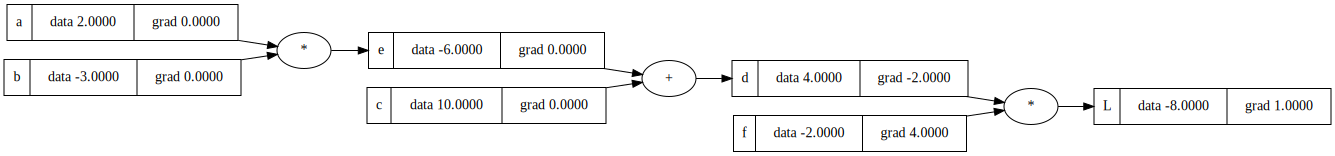

In [152]:
# dL / dd = ? and dL / df = ?
# we know L = d*f
# h -> 0

# (f(x + h) - f(x)) / h
# ((d + h)*f - d*f) / h
# (d*f + h*f - d*f) / h
# (h*f) / h
# f

d.grad = f.data
# similarly, dL / df = d
f.grad = d.data

check_derivative(d)
check_derivative(f)

draw_graph(L)

-1.9999999999988916
-2.000000000000668


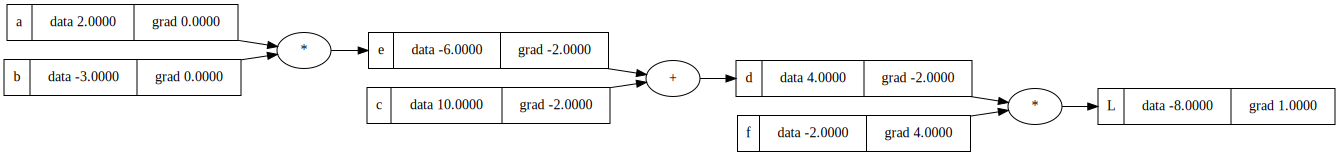

In [153]:
# dL / dc = ? and dL / de = ?
# How to derive dL / dc ?
# we know dL / dd
# h -> 0

# dd / dc = ? and dd / de = ?
# we know d = c + e
# h -> 0

# (f(x + h) - f(x)) / h
# ((c + h + e) - (c + e)) / h
# (c + h + e - c - e) / h
# h / h
# 1.0

# dd/dc = 1.0 and similarly, dd / de = 1.0


# How c impacts L through d?
# Chain rule
# we know dL/dd, dd/dc
# dL / dc = (dL / dd) * (dd / dc)

c.grad = -2.0
# similarly, e.grad = -2.0
e.grad = -2.0

# + node just propagates the gradient
check_derivative(c)
check_derivative(e)
draw_graph(L)

6.000000000000227
-3.9999999999995595


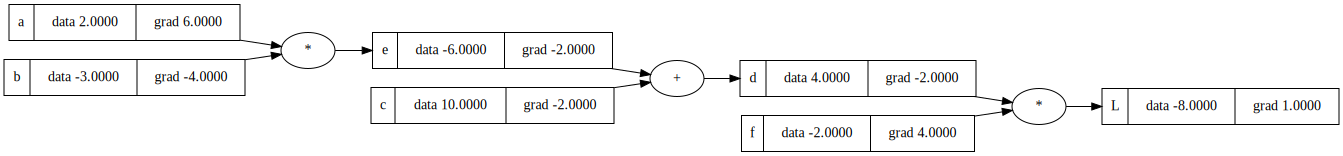

In [156]:
# dL / da = ? and dL / db = ?
# we know dL / de = -2.0
# chain rule => dl / da = (dL / de) * (de / da)

# e = a * b
# de / da = ?
# de / da = b = -3.0 
# de / db = a = 2.0

a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

check_derivative(a)
check_derivative(b)
draw_dot(L)

In [85]:
# Change the values by some small step
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

# We expect L to go up because we moved in the direction of the gradient
print(L.data)

-7.286496


### Manual backpropagation - neuron